In [2350]:
#Khoá luận nghiên cứu cải tiến Thuật Toán Random Forest của lập trình viên **Trịnh Minh Hiếu** (Trường ĐH Kinh Bắc-UKB) 
#được dẫn dắt bởi **TS.Trần Đức Nghĩa** (Viện Hàn Lâm & Khoa Học Công Nghệ Việt Nam-VAST) 
#và **Thầy Đỗ Viết Mạnh** (Viện Công Nghệ Thông Tin-IOIT)

#Thư viện học máy skcitlearn 
#Trinh Minh Hieu : thay doi Normal Walking thanh Normal_walking trong excel de nhan dien ket qua chinh xac hon
#viec de Normal Walking se gay nham lan trong ket qua du doan!
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

from scipy import signal

feature_names = ['mean_x', 'mean_y', 'mean_z',
                 'mean_x2', 'mean_y2', 'mean_z2',
                 'rms_x', 'rms_y', 'rms_z',
                 'rms_x2', 'rms_y2', 'rms_z2',
                 'std_x', 'std_y', 'std_z',
                 'std_x2', 'std_y2', 'std_z2',
                 'min_x', 'min_y', 'min_z',
                 'min_x2', 'min_y2', 'min_z2',
                 'max_x', 'max_y', 'max_z',
                 'max_x2', 'max_y2', 'max_z2'] #total array = 30

target_names = ['Feeding', 'Lying', 'Standing', 'Normal_walking'] #muc tieu du doan hanh vi cua bo: cho an,nawm,dung,di dao

#doi so at va fs
#at-action

def featuresFromBuffer(at, fs):
    #np.zeros() Trả về một mảng mới có hình dạng và kiểu đã cho, chứa đầy các số không.
    feat = np.zeros(36) #30 o day la size of feature_names
#iloc[]Lập chỉ mục hoàn toàn dựa trên vị trí số nguyên để lựa chọn theo vị trí.
#.iloc[]chủ yếu dựa trên vị trí số nguyên (từ 0đến length-1của trục), nhưng cũng có thể được sử dụng với một mảng boolean.
    x = np.array(at.iloc[:,0], dtype=np.float64)   # x acceleration component (leg)
    y = np.array(at.iloc[:,1], dtype=np.float64)   # y
    z = np.array(at.iloc[:,2], dtype=np.float64)   # z
    x2 = np.array(at.iloc[:,3], dtype=np.float64)   # x2 acceleration component (collar)
    y2 = np.array(at.iloc[:,4], dtype=np.float64)   # y2
    z2 = np.array(at.iloc[:,5], dtype=np.float64)   # z2
#by hieu numpy.float64.hex()
    
# np.mean()
# Tính toán trung bình cộng dọc theo trục xác định.
# Trả về giá trị trung bình của các phần tử mảng. Giá trị trung bình được lấy trên mảng phẳng theo mặc định,
# nếu không thì trên trục được chỉ định. float64giá trị trung gian và giá trị trả về được sử dụng cho các đầu vào số nguyên
    # Average value in signal buffer for all three acceleration components (1 each)    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means
    means2 = [np.mean(i) for i in [x2, y2, z2]]
    feat[3:6] = means2
    #np.sqrt() Trả về căn bậc hai không âm của một mảng, tính theo phần tử.
    #doan nay dung danh gia RMSE
    # RMS value in signal buffer for all three acceleration components (1 each)
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[6:9] = rms
    rms2 = [np.sqrt(np.mean(i**2)) for i in [x2, y2, z2]]
    feat[9:12] = rms2
#    np.std()
#     Tính toán độ lệch chuẩn dọc theo trục được chỉ định.
# Trả về độ lệch chuẩn, thước đo mức độ lan truyền của phân phối, 
# của các phần tử mảng. Độ lệch chuẩn được tính cho mảng phẳng theo mặc định, nếu không thì trên trục được chỉ định.
    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[12:15] = std
    std2 = [np.std(i) for i in [x2, y2, z2]]
    feat[15:18] = std2 

    # Variance
    #var = [np.var(i) for i in [x, y, z]]
    #feat[9:12] = var
    
    # Median
    #med = [np.median(i) for i in [x, y, z]]
    #feat[12:15] = med
    
#     np.amin()
#     Trả về giá trị tối thiểu của một mảng hoặc giá trị tối thiểu dọc theo một trục.
    # Range
    Range1 = [ np.amin(i) for i in [x, y, z]]    
    feat[18:21] = Range1
    Range2 = [ np.amax(i) for i in [x, y, z]]    
    feat[21:24] = Range2
    Range12 = [ np.amin(i) for i in [x2, y2, z2]]    
    feat[24:27] = Range12
    Range22 = [ np.amax(i) for i in [x2, y2, z2]]    
    feat[27:30] = Range22
#np.median()
# Tính toán trung vị dọc theo trục được chỉ định.
# Trả về giá trị trung bình của các phần tử mảng.
    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[30:33] = med
    med2 = [np.median(i) for i in [x2, y2, z2]]
    feat[33:36] = med2
        
    return feat
    

In [2351]:
# Import data|read_excel|read_csv

#data lay tu file excel 
df = pd.read_excel('4CowData_2sensor.xlsx')

#df = df.drop(columns=['Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23'])


In [2352]:
#add by trinh minh hieu
df.info

<bound method DataFrame.info of            Feeding    Unnamed: 1    Unnamed: 2    Unnamed: 3    Unnamed: 4  \
0     Acc in x (g)  Acc in y (g)  Acc in z (g)  Acc in x (g)  Acc in y (g)   
1      -885.942857      4.485714    160.028571        -754.9         120.3   
2           -871.1         -25.7         212.3   -722.111111     86.555556   
3           -884.5         -64.2         122.3        -790.2          11.4   
4      -872.111111   -191.555556     93.666667        -823.5         184.4   
...            ...           ...           ...           ...           ...   
6595           NaN           NaN           NaN           NaN           NaN   
6596           NaN           NaN           NaN           NaN           NaN   
6597           NaN           NaN           NaN           NaN           NaN   
6598           NaN           NaN           NaN           NaN           NaN   
6599           NaN           NaN           NaN           NaN           NaN   

        Unnamed: 5         Lyin

In [2353]:
#thong ke khung du lieu
df.describe()

,Feeding,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Lying,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Nhai lai,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
count,4482.0,4482,4482,4482,4482.0,4482.0,804,804,804,804.0,...,2033.000000,2033.0,2033.0,2033.0,1,1,1,1,1,1
unique,1693.0,3264,3061,3536,3189.0,3104.0,314,207,417,684.0,...,1936.000000,1208.0,1611.0,1341.0,1,1,1,1,1,1
top,-899.3,-76,62,-431,333.2,-743.6,0,0,0,-826.9,...,-139.111111,-868.7,-63.1,-282.3,Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g)
freq,19.0,7,7,5,7.0,7.0,250,250,250,5.0,...,3.000000,9.0,5.0,7.0,1,1,1,1,1,1


In [2354]:
#tham khao voi ten cot
df.columns

Index(['Feeding', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Lying', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Standing', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Normal_walking',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Nhai lai', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29'],
      dtype='object')

In [2355]:
#Được thêm bởi Trinh Minh Hieu - 2022
#doc tap du lieu 5 rows × 30 columns
#kiểm tra tình trạng của nó và các giá trị bị thiếu có tồn tại hay không
df.head()


,Feeding,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Lying,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Nhai lai,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),...,Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g)
1,-885.942857,4.485714,160.028571,-754.9,120.3,-489.6,0,0,0,-80.7,...,-99.666667,-811.6,167.6,-439.9,NaN,NaN,NaN,NaN,NaN,NaN
2,-871.1,-25.7,212.3,-722.111111,86.555556,-610.444444,0,0,0,-77.4,...,69.222222,-863.7,-55.9,-432.8,NaN,NaN,NaN,NaN,NaN,NaN
3,-884.5,-64.2,122.3,-790.2,11.4,-465.2,0,0,0,-67.9,...,-172.3,-746.555556,149.111111,-740.555556,NaN,NaN,NaN,NaN,NaN,NaN
4,-872.111111,-191.555556,93.666667,-823.5,184.4,-412.8,0,0,0,-94.111111,...,34.8,-645.5,-235.5,-541.7,NaN,NaN,NaN,NaN,NaN,NaN


In [2356]:
df

,Feeding,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Lying,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Nhai lai,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),...,Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g),Acc in x (g),Acc in y (g),Acc in z (g)
1,-885.942857,4.485714,160.028571,-754.9,120.3,-489.6,0,0,0,-80.7,...,-99.666667,-811.6,167.6,-439.9,NaN,NaN,NaN,NaN,NaN,NaN
2,-871.1,-25.7,212.3,-722.111111,86.555556,-610.444444,0,0,0,-77.4,...,69.222222,-863.7,-55.9,-432.8,NaN,NaN,NaN,NaN,NaN,NaN
3,-884.5,-64.2,122.3,-790.2,11.4,-465.2,0,0,0,-67.9,...,-172.3,-746.555556,149.111111,-740.555556,NaN,NaN,NaN,NaN,NaN,NaN
4,-872.111111,-191.555556,93.666667,-823.5,184.4,-412.8,0,0,0,-94.111111,...,34.8,-645.5,-235.5,-541.7,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2357]:
#https://stackoverflow.com/questions/54317168/plotting-a-dataframe-with-seaborn-pairplot-in-multiple-colors
# import seaborn as sns
# df = Feeding.dropna() #ham dropna() loai bo nhan Acc in x (g) do chua chuoi

# sns.displot(df['Feeding'])

In [2358]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_excel('4CowData_2sensor.xlsx')
df.columns


Index(['Feeding', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Lying', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Standing', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Normal_walking',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Nhai lai', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29'],
      dtype='object')

In [2359]:
#Được thêm bởi Trinh Minh Hieu - 2022
df.Feeding.nunique() #Feeding lay tu cot excel
df.Lying.nunique()
df.Standing.nunique()
df.Normal_walking.nunique()

#số lượng duy nhất trong tập dữ liệu.
# Feeding 1693
# Lying 314
# Standing 1829
# Normal_walking 1881

1693

314

1829

1881

In [2360]:
# Prepare data
# load du lieu tu file excel

#Được thêm bởi Trinh Minh Hieu - 2022

#Phương dropna()thức loại bỏ các hàng có chứa giá trị NULL.
#Phương dropna()thức trả về một đối tượng DataFrame mới trừ khi inplacetham số được đặt thành True,
#trong trường hợp đó, dropna()phương thức thực hiện việc xóa trong DataFrame(Feeding) ban đầu.

# RangeIndex()
# Chỉ mục bất biến triển khai một phạm vi số nguyên đơn điệu.
# RangeIndex là một trường hợp đặc biệt tiết kiệm bộ nhớ của Int64Index được giới hạn để đại diện cho các phạm vi đơn điệu. Sử dụng RangeIndex trong một số trường hợp có thể cải thiện tốc độ tính toán.
# Đây là loại chỉ mục mặc định được DataFrame và Series sử dụng khi người dùng không cung cấp chỉ mục rõ ràng.

# Hàm drop () được sử dụng để loại bỏ các nhãn được chỉ định từ các hàng hoặc cột.
# Loại bỏ các hàng hoặc cột bằng cách chỉ định tên nhãn và trục tương ứng hoặc bằng cách chỉ định trực tiếp tên chỉ mục hoặc cột.
# Khi sử dụng nhiều chỉ mục, các nhãn ở các cấp độ khác nhau có thể bị xóa bằng cách chỉ định cấp độ.

#ăn,cho ăn
Feeding = df[['Feeding', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']]
Feeding = Feeding.dropna() #xoa nhan Acc in x,y,z
Feeding.index = pd.RangeIndex(len(Feeding.index))
Feeding = Feeding.drop(0) #xoa cot Feeding,hàm drop() loại bỏ giá trị nào đó được chỉ định trong cột

#nằm
Lying = df[['Lying', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']]
Lying = Lying.dropna()
Lying.index = pd.RangeIndex(len(Lying.index))
Lying = Lying.drop(0)
#đứng
Standing = df[['Standing', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17']]
Standing = Standing.dropna()
Standing.index = pd.RangeIndex(len(Standing.index))
Standing = Standing.drop(0)
#đi dạo
Normal_walking = df[['Normal_walking', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23']]
Normal_walking = Normal_walking.dropna()
Normal_walking.index = pd.RangeIndex(len(Normal_walking.index))
Normal_walking = Normal_walking.drop(0)


In [2361]:
#Được thêm bởi Trinh Minh Hieu - 2022
# irand = int(len(Feeding)*train_ratio)
# irand
#int(len(Feeding)*train_ratio) = 2688

In [2362]:
#Được thêm bởi Trinh Minh Hieu - 2022
# feed = int(len(Feeding))
# feed
#int(len(Feeding)) = 4481

In [2363]:
# tol = 100
# tra = 60 #16 ngau nhien tu 20 còn lại 4 co dinh
# te = 40


In [2364]:
# nb_samples = Feeding
# list([nb_samples])

In [2365]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# #nb_samples 100% tap du lieu ban dau
# #train_test=0.6(60%) lay ngau nhien 60%cua tap du lieu kiem tra,con lai co dinh (mac dinh test_size=0.4)
# train_test_split(nb_samples,train_size=0.6)


In [2366]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# #100/10 = 10
# X,y = np.arange(100).reshape((10, 10)), range(10)
# X_train, X_test, x_train, x_test = train_test_split(X, y, train_size=0.66)

In [2367]:
# y

In [2368]:
# list(y)

In [2369]:
# X_test

In [2370]:
# X_train

In [2371]:
# X_test

In [2372]:
#nb_samples 100% tap du lieu ban dau
#train_test=0.6(60%) lay ngau nhien 60%cua tap du lieu kiem tra,con lai co dinh (mac dinh test_size=0.4)
# import numpy as np
# from sklearn.model_selection import train_test_split

# train_ratio = 0.6 #60% lấy 60% để phân tích
# ratio_test = 0.4
# stride=6
# window_size =16
# # df=dataframe mot khung du lieu

# # X = Feeding
# #giờ em hiểu ra là hai biến X_train, X_test  chính là hai mảng khi dùng hàm train_test_split khi đó đặt train_size=0.6 thì khi đó X_train là mảng tách 60%,còn lại X_test  là mảng còn lại 40%
# # X_train,X_test,y_train,y_test = train_test_split(Feeding.index,y,test_size=0.4)
# # X.iloc[X_train]
# # y.iloc[y_test]
# # train, test = train_test_split(df,test_size=0.4)
# # X_train, X_val = train_test_split(X_train,test_size=0.6)
# # ham ngau nhien ket qua trong khoang dc chi dinh
# behavior_origin = [Feeding[i:i+window_size] for i in range(0, len(Feeding), stride) if i+window_size<=int(len(Feeding))]

# feeding_train, feeding_test = train_test_split(behavior_origin, train_size=0.6) #0.602-

# len(Feeding)
# len(behavior_origin)
# len(feeding_train)
# len(feeding_test)
# # print('Y_feeding_Train: ', len(feeding_train)) #X
# # print('X_feeding_Test: ', len(feeding_test)) #y

# list([Y_train])

In [2373]:
# thuc hien windowing du lieu
# chia moi khoi du lieu 16s
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
window_size = 16 #kích thước cửa sổ or kích thước lô
stride = 6 #tăng chuỗi lên 6 vd: for(1,26,6) -> 1,6,...trong khoảng 26
#nb_samples = int(len(Feeding)*1.0) #100%
train_ratio = 0.6 #60% lấy 60% để phân tích
ratio_test = 0.4


#trinh minh hieu
#ma trận nhầm lẫn     Confusion Matrix
#trong thực tế, 60 lần sự kiện được đề cập đã xảy ra và 40 lần thì không.
#Ma trận nhầm lẫn cho chiến lược đào tạo 60% và kiểm tra 40%.

behavior_feeding = [Feeding[i:i+window_size] for i in range(0, int(len(Feeding)), stride) if i+window_size<=int(len(Feeding))]
X_feeding_train, X_feeding_test = train_test_split(behavior_feeding, train_size=0.6) 

# len(Feeding)
# len(behavior_origin)
# len(feeding_train)
# len(feeding_test)
behavior_lying = [Lying[i:i+window_size] for i in range(0, int(len(Lying)), stride) if i+window_size<=int(len(Feeding))]
X_lying_train, X_lying_test = train_test_split(behavior_lying, train_size=0.6) 

behavior_standing = [Standing[i:i+window_size] for i in range(0, int(len(Standing)), stride) if i+window_size<=int(len(Standing))]
X_standing_train, X_standing_test = train_test_split(behavior_standing, train_size=0.6) 

behavior_walking = [Normal_walking[i:i+window_size] for i in range(0, int(len(Normal_walking)), stride) if i+window_size<=int(len(Normal_walking))]
X_normalw_train, X_normalw_test = train_test_split(behavior_walking , train_size=0.6) 

# X_lying_train = [Lying[i:i+window_size] for i in range(0, lyi, stride) if i+window_size<=int(len(Lying))]
# X_lying_test = [Lying[i:i+window_size] for i in range(int(len(Lying)*train_ratio), len(Lying), stride) if i+window_size<=len(Lying)]

# X_standing_train = [Standing[i:i+window_size] for i in range(0, sta, stride) if i+window_size<=int(len(Standing))]
# X_standing_test = [Standing[i:i+window_size] for i in range(int(len(Standing)*train_ratio), len(Standing), stride) if i+window_size<=len(Standing)]

# X_normalw_train = [Normal_walking[i:i+window_size] for i in range(0, nor, stride) if i+window_size<=int(len(Normal_walking))]
# X_normalw_test = [Normal_walking[i:i+window_size] for i in range(int(len(Normal_walking)*train_ratio), len(Normal_walking), stride) if i+window_size<=len(Normal_walking)]


print('Y_feeding_Train: ', len(X_feeding_train)) #X
print('X_feeding_Test: ', len(X_feeding_test)) #y

print('Y_lying_Train: ', len(X_lying_train)) #X
print('X_lying_Test: ', len(X_lying_test)) #y

print('Y_standing_Train: ', len(X_standing_train)) #X
print('X_standing_Test: ', len(X_standing_test)) #y

print('Y_walking_Train: ', len(X_normalw_train)) #X
print('X_walking_Test: ', len(X_normalw_test)) #y

print('Total: \n')
print('Train: ', len(X_feeding_train)+len(X_lying_train)+len(X_standing_train)+len(X_normalw_train))
print('Test: ', len(X_feeding_test)+len(X_lying_test)+len(X_standing_test)+ len(X_normalw_test)) #chỉnh sửa bỏi trinh minh hieu train thanh test

# ket qua goc

# X_feeding_train:  448
# X_feeding_test:  297
# X_lying_train:  81
# X_lying_test:  52
# X_standing_train:  660
# X_standing_test:  438
# X_normalw_train:  204
# X_normalw_test:  133
# Total: 

# Train:  1393
# Train:  920

Y_feeding_Train:  447
X_feeding_Test:  298
Y_lying_Train:  80
X_lying_Test:  54
Y_standing_Train:  658
X_standing_Test:  440
Y_walking_Train:  202
X_walking_Test:  135
Total: 

Train:  1387
Test:  927


In [2374]:
#Catch 'em all

my_train_data = []
my_train_lable = []

my_test_data = []
my_test_lable = []

for acts in X_feeding_train:
    my_train_data.append(acts)
    my_train_lable.append(0)

for acts in X_lying_train:
    my_train_data.append(acts)
    my_train_lable.append(1)
    
for acts in X_standing_train:
    my_train_data.append(acts)
    my_train_lable.append(2)  

for acts in X_normalw_train:
    my_train_data.append(acts)
    my_train_lable.append(3)

    
print('my-train-data\'s length: ', len(my_train_data) )
print('my-train-lable\'s length: ', len(my_train_lable) )

#Catch 'em all

for acts in X_feeding_test:
    my_test_data.append(acts)
    my_test_lable.append(0)

for acts in X_lying_test:
    my_test_data.append(acts)
    my_test_lable.append(1)
    
for acts in X_standing_test:
    my_test_data.append(acts)
    my_test_lable.append(2)

for acts in X_normalw_test:
    my_test_data.append(acts)
    my_test_lable.append(3)
    
print('my-test-data\'s length: ', len(my_test_data) )
print('my-test-lable\'s length: ', len(my_test_lable) )

my-train-data's length:  1387
my-train-lable's length:  1387
my-test-data's length:  927
my-test-lable's length:  927


In [2375]:
train_features = []
test_features = []

for action in my_train_data:
    feat = featuresFromBuffer(action, 1)
    train_features.append(feat)

for action in my_test_data:
    feat = featuresFromBuffer(action, 1)
    test_features.append(feat)
    
len(train_features)
len(test_features)

1387

927

In [2376]:
# beginning of classification:

print("Decision Tree stuffs:")
from sklearn.tree import DecisionTreeClassifier #Cây quyết định 

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, my_train_lable)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'
     .format(clf2.score(train_features, my_train_lable)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
     .format(clf2.score(test_features, my_test_lable)))



print("\n\nDecision Tree DTBD stuffs:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.5, max_depth=3, n_estimators=100).fit(train_features, my_train_lable)

print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, my_train_lable)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, my_test_lable)))


print("\n\nSVM stuffs:")
this_C = 100
clf = SVC(C=this_C).fit(train_features, my_train_lable)
print("Accuracy on training set: {:.2f}".format(clf.score(train_features, my_train_lable)))
print("Accuracy on test set: {:.2f}".format(clf.score(test_features, my_test_lable)))

#Accuracy of RF classifier on training set: 1.000
#Accuracy of RF classifier on test set: 0.886
import numbers
from warnings import catch_warnings, simplefilter, warn
import threading

from abc import ABCMeta, abstractmethod
import numpy as np
from scipy.sparse import issparse
from scipy.sparse import hstack as sparse_hstack
from joblib import Parallel

from sklearn.base import is_classifier
from sklearn.base import ClassifierMixin, MultiOutputMixin, RegressorMixin
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import (
    DecisionTreeClassifier, #cây quyết định,quan trong !k xoá
    DecisionTreeRegressor,
    ExtraTreeClassifier,
    ExtraTreeRegressor,
)
from sklearn.tree._tree import DTYPE, DOUBLE
from sklearn.utils import check_random_state, compute_sample_weight, deprecated
from sklearn.exceptions import DataConversionWarning
from sklearn.ensemble._base import BaseEnsemble, _partition_estimators
from sklearn.utils.fixes import delayed
from sklearn.utils.fixes import _joblib_parallel_args
from sklearn.utils.multiclass import check_classification_targets, type_of_target
from sklearn.utils.validation import check_is_fitted, _check_sample_weight
from sklearn.utils.validation import _num_samples


__all__ = [
    "RandomForestClassifier",
]

MAX_INT = np.iinfo(np.int32).max

def _get_n_samples_bootstrap(n_samples, max_samples):
    """
    Get the number of samples in a bootstrap sample.
    Parameters
    ----------
    n_samples : int
        Number of samples in the dataset.
    max_samples : int or float
        The maximum number of samples to draw from the total available:
            - if float, this indicates a fraction of the total and should be
              the interval `(0.0, 1.0]`;
            - if int, this indicates the exact number of samples;
            - if None, this indicates the total number of samples.
    Returns
    -------
    n_samples_bootstrap : int
        The total number of samples to draw for the bootstrap sample.
    """
    if max_samples is None:
        return n_samples

    if isinstance(max_samples, numbers.Integral):
        if not (1 <= max_samples <= n_samples):
            msg = "`max_samples` must be in range 1 to {} but got value {}"
            raise ValueError(msg.format(n_samples, max_samples))
        return max_samples

    if isinstance(max_samples, numbers.Real):
        if not (0 < max_samples <= 1):
            msg = "`max_samples` must be in range (0.0, 1.0] but got value {}"
            raise ValueError(msg.format(max_samples))
        return round(n_samples * max_samples)

    msg = "`max_samples` should be int or float, but got type '{}'"
    raise TypeError(msg.format(type(max_samples)))


def _generate_sample_indices(random_state, n_samples, n_samples_bootstrap):
    """
    Private function used to _parallel_build_trees function."""

    random_instance = check_random_state(random_state)
    sample_indices = random_instance.randint(0, n_samples, n_samples_bootstrap)

    return sample_indices


def _generate_unsampled_indices(random_state, n_samples, n_samples_bootstrap):
    """
    Private function used to forest._set_oob_score function."""
    sample_indices = _generate_sample_indices(
        random_state, n_samples, n_samples_bootstrap
    )
    sample_counts = np.bincount(sample_indices, minlength=n_samples)
    unsampled_mask = sample_counts == 0
    indices_range = np.arange(n_samples)
    unsampled_indices = indices_range[unsampled_mask]

    return unsampled_indices


def _parallel_build_trees(
    tree,
    forest,
    X,
    y,
    sample_weight,
    tree_idx,
    n_trees,
    verbose=0,
    class_weight=None,
    n_samples_bootstrap=None,
):
    """
    Private function used to fit a single tree in parallel."""
    if verbose > 1:
        print("building tree %d of %d" % (tree_idx + 1, n_trees))

    if forest.bootstrap:
        n_samples = X.shape[0]
        if sample_weight is None:
            curr_sample_weight = np.ones((n_samples,), dtype=np.float64)
        else:
            curr_sample_weight = sample_weight.copy()

        indices = _generate_sample_indices(
            tree.random_state, n_samples, n_samples_bootstrap
        )
        sample_counts = np.bincount(indices, minlength=n_samples)
        curr_sample_weight *= sample_counts

        if class_weight == "subsample":
            with catch_warnings():
                simplefilter("ignore", DeprecationWarning)
                curr_sample_weight *= compute_sample_weight("auto", y, indices=indices)
        elif class_weight == "balanced_subsample":
            curr_sample_weight *= compute_sample_weight("balanced", y, indices=indices)

        tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
    else:
        tree.fit(X, y, sample_weight=sample_weight, check_input=False)

    return tree


class BaseForest(MultiOutputMixin, BaseEnsemble, metaclass=ABCMeta):
    """
    Base class for forests of trees.
    Warning: This class should not be used directly. Use derived classes
    instead.
    """

    @abstractmethod
    def __init__(
        self,
        base_estimator,
        n_estimators=100,
        *,
        estimator_params=tuple(),
        bootstrap=False,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        max_samples=None,
    ):
        super().__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            estimator_params=estimator_params,
        )

        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        self.warm_start = warm_start
        self.class_weight = class_weight
        self.max_samples = max_samples

    def apply(self, X):
        """
        Apply trees in the forest to X, return leaf indices.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, its dtype will be converted to
            ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csr_matrix``.
        Returns
        -------
        X_leaves : ndarray of shape (n_samples, n_estimators)
            For each datapoint x in X and for each tree in the forest,
            return the index of the leaf x ends up in.
        """
        X = self._validate_X_predict(X)
        results = Parallel(
            n_jobs=self.n_jobs,
            verbose=self.verbose,
            **_joblib_parallel_args(prefer="threads"),
        )(delayed(tree.apply)(X, check_input=False) for tree in self.estimators_)

        return np.array(results).T

    def decision_path(self, X):
        """
        Return the decision path in the forest.
        .. versionadded:: 0.18
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, its dtype will be converted to
            ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csr_matrix``.
        Returns
        -------
        indicator : sparse matrix of shape (n_samples, n_nodes)
            Return a node indicator matrix where non zero elements indicates
            that the samples goes through the nodes. The matrix is of CSR
            format.
        n_nodes_ptr : ndarray of shape (n_estimators + 1,)
            The columns from indicator[n_nodes_ptr[i]:n_nodes_ptr[i+1]]
            gives the indicator value for the i-th estimator.
        """
        X = self._validate_X_predict(X)
        indicators = Parallel(
            n_jobs=self.n_jobs,
            verbose=self.verbose,
            **_joblib_parallel_args(prefer="threads"),
        )(
            delayed(tree.decision_path)(X, check_input=False)
            for tree in self.estimators_
        )

        n_nodes = [0]
        n_nodes.extend([i.shape[1] for i in indicators])
        n_nodes_ptr = np.array(n_nodes).cumsum()

        return sparse_hstack(indicators).tocsr(), n_nodes_ptr

    def fit(self, X, y, sample_weight=None):
        """
        Build a forest of trees from the training set (X, y).
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Internally, its dtype will be converted
            to ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csc_matrix``.
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted. Splits
            that would create child nodes with net zero or negative weight are
            ignored while searching for a split in each node. In the case of
            classification, splits are also ignored if they would result in any
            single class carrying a negative weight in either child node.
        Returns
        -------
        self : object
            Fitted estimator.
        """
        # Validate or convert input data
        if issparse(y):
            raise ValueError("sparse multilabel-indicator for y is not supported.")
        X, y = self._validate_data(
            X, y, multi_output=True, accept_sparse="csc", dtype=DTYPE
        )
        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X)

        if issparse(X):
            # Pre-sort indices to avoid that each individual tree of the
            # ensemble sorts the indices.
            X.sort_indices()

        y = np.atleast_1d(y)
        if y.ndim == 2 and y.shape[1] == 1:
            warn(
                "A column-vector y was passed when a 1d array was"
                " expected. Please change the shape of y to "
                "(n_samples,), for example using ravel().",
                DataConversionWarning,
                stacklevel=2,
            )

        if y.ndim == 1:
            # reshape is necessary to preserve the data contiguity against vs
            # [:, np.newaxis] that does not.
            y = np.reshape(y, (-1, 1))

        if self.criterion == "poisson":
            if np.any(y < 0):
                raise ValueError(
                    "Some value(s) of y are negative which is "
                    "not allowed for Poisson regression."
                )
            if np.sum(y) <= 0:
                raise ValueError(
                    "Sum of y is not strictly positive which "
                    "is necessary for Poisson regression."
                )

        self.n_outputs_ = y.shape[1]

        y, expanded_class_weight = self._validate_y_class_weight(y)

        if getattr(y, "dtype", None) != DOUBLE or not y.flags.contiguous:
            y = np.ascontiguousarray(y, dtype=DOUBLE)

        if expanded_class_weight is not None:
            if sample_weight is not None:
                sample_weight = sample_weight * expanded_class_weight
            else:
                sample_weight = expanded_class_weight

        if not self.bootstrap and self.max_samples is not None:
            raise ValueError(
                "`max_sample` cannot be set if `bootstrap=False`. "
                "Either switch to `bootstrap=True` or set "
                "`max_sample=None`."
            )
        elif self.bootstrap:
            n_samples_bootstrap = _get_n_samples_bootstrap(
                n_samples=X.shape[0], max_samples=self.max_samples
            )
        else:
            n_samples_bootstrap = None

        # Check parameters
        self._validate_estimator()
        # TODO: Remove in v1.2
       

        if not self.bootstrap and self.oob_score:
            raise ValueError("Out of bag estimation only available if bootstrap=True")

        random_state = check_random_state(self.random_state)

        if not self.warm_start or not hasattr(self, "estimators_"):
            # Free allocated memory, if any
            self.estimators_ = []

        n_more_estimators = self.n_estimators - len(self.estimators_)

        if n_more_estimators < 0:
            raise ValueError(
                "n_estimators=%d must be larger or equal to "
                "len(estimators_)=%d when warm_start==True"
                % (self.n_estimators, len(self.estimators_))
            )

        elif n_more_estimators == 0:
            warn(
                "Warm-start fitting without increasing n_estimators does not "
                "fit new trees."
            )
        else:
            if self.warm_start and len(self.estimators_) > 0:
                # We draw from the random state to get the random state we
                # would have got if we hadn't used a warm_start.
                random_state.randint(MAX_INT, size=len(self.estimators_))

            trees = [
                self._make_estimator(append=False, random_state=random_state)
                for i in range(n_more_estimators)
            ]

            # Parallel loop: we prefer the threading backend as the Cython code
            # for fitting the trees is internally releasing the Python GIL
            # making threading more efficient than multiprocessing in
            # that case. However, for joblib 0.12+ we respect any
            # parallel_backend contexts set at a higher level,
            # since correctness does not rely on using threads.
            trees = Parallel(
                n_jobs=self.n_jobs,
                verbose=self.verbose,
                **_joblib_parallel_args(prefer="threads"),
            )(
                delayed(_parallel_build_trees)(
                    t,
                    self,
                    X,
                    y,
                    sample_weight,
                    i,
                    len(trees),
                    verbose=self.verbose,
                    class_weight=self.class_weight,
                    n_samples_bootstrap=n_samples_bootstrap,
                )
                for i, t in enumerate(trees)
            )

            # Collect newly grown trees
            self.estimators_.extend(trees)

        if self.oob_score:
            y_type = type_of_target(y)
            if y_type in ("multiclass-multioutput", "unknown"):
                # FIXME: we could consider to support multiclass-multioutput if
                # we introduce or reuse a constructor parameter (e.g.
                # oob_score) allowing our user to pass a callable defining the
                # scoring strategy on OOB sample.
                raise ValueError(
                    "The type of target cannot be used to compute OOB "
                    f"estimates. Got {y_type} while only the following are "
                    "supported: continuous, continuous-multioutput, binary, "
                    "multiclass, multilabel-indicator."
                )
            self._set_oob_score_and_attributes(X, y)

        # Decapsulate classes_ attributes
        if hasattr(self, "classes_") and self.n_outputs_ == 1:
            self.n_classes_ = self.n_classes_[0]
            self.classes_ = self.classes_[0]

        return self

    @abstractmethod
    def _set_oob_score_and_attributes(self, X, y):
        """Compute and set the OOB score and attributes.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data matrix.
        y : ndarray of shape (n_samples, n_outputs)
            The target matrix.
        """

    def _compute_oob_predictions(self, X, y):
        """Compute and set the OOB score.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data matrix.
        y : ndarray of shape (n_samples, n_outputs)
            The target matrix.
        Returns
        -------
        oob_pred : ndarray of shape (n_samples, n_classes, n_outputs) or \
                (n_samples, 1, n_outputs)
            The OOB predictions.
        """
        # Prediction requires X to be in CSR format
        if issparse(X):
            X = X.tocsr()

        n_samples = y.shape[0]
        n_outputs = self.n_outputs_
        if is_classifier(self) and hasattr(self, "n_classes_"):
            # n_classes_ is a ndarray at this stage
            # all the supported type of target will have the same number of
            # classes in all outputs
            oob_pred_shape = (n_samples, self.n_classes_[0], n_outputs)
        else:
            # for regression, n_classes_ does not exist and we create an empty
            # axis to be consistent with the classification case and make
            # the array operations compatible with the 2 settings
            oob_pred_shape = (n_samples, 1, n_outputs)

        oob_pred = np.zeros(shape=oob_pred_shape, dtype=np.float64)
        n_oob_pred = np.zeros((n_samples, n_outputs), dtype=np.int64)

        n_samples_bootstrap = _get_n_samples_bootstrap(
            n_samples,
            self.max_samples,
        )
        for estimator in self.estimators_:
            unsampled_indices = _generate_unsampled_indices(
                estimator.random_state,
                n_samples,
                n_samples_bootstrap,
            )

            y_pred = self._get_oob_predictions(estimator, X[unsampled_indices, :])
            oob_pred[unsampled_indices, ...] += y_pred
            n_oob_pred[unsampled_indices, :] += 1

        for k in range(n_outputs):
            if (n_oob_pred == 0).any():
                warn(
                    "Some inputs do not have OOB scores. This probably means "
                    "too few trees were used to compute any reliable OOB "
                    "estimates.",
                    UserWarning,
                )
                n_oob_pred[n_oob_pred == 0] = 1
            oob_pred[..., k] /= n_oob_pred[..., [k]]

        return oob_pred

    def _validate_y_class_weight(self, y):
        # Default implementation
        return y, None

    def _validate_X_predict(self, X):
        """
        Validate X whenever one tries to predict, apply, predict_proba."""
        check_is_fitted(self)
        X = self._validate_data(X, dtype=DTYPE, accept_sparse="csr", reset=False)
        if issparse(X) and (X.indices.dtype != np.intc or X.indptr.dtype != np.intc):
            raise ValueError("No support for np.int64 index based sparse matrices")
        return X

    @property
    def feature_importances_(self):
        """
        The impurity-based feature importances.
        The higher, the more important the feature.
        The importance of a feature is computed as the (normalized)
        total reduction of the criterion brought by that feature.  It is also
        known as the Gini importance.
        Warning: impurity-based feature importances can be misleading for
        high cardinality features (many unique values). See
        :func:`sklearn.inspection.permutation_importance` as an alternative.
        Returns
        -------
        feature_importances_ : ndarray of shape (n_features,)
            The values of this array sum to 1, unless all trees are single node
            trees consisting of only the root node, in which case it will be an
            array of zeros.
        """
        check_is_fitted(self)

        all_importances = Parallel(
            n_jobs=self.n_jobs, **_joblib_parallel_args(prefer="threads")
        )(
            delayed(getattr)(tree, "feature_importances_")
            for tree in self.estimators_
            if tree.tree_.node_count > 1
        )

        if not all_importances:
            return np.zeros(self.n_features_in_, dtype=np.float64)

        all_importances = np.mean(all_importances, axis=0, dtype=np.float64)
        return all_importances / np.sum(all_importances)

    # TODO: Remove in 1.2
    # mypy error: Decorated property not supported
    @deprecated(  # type: ignore
        "Attribute `n_features_` was deprecated in version 1.0 and will be "
        "removed in 1.2. Use `n_features_in_` instead."
    )
    @property
    def n_features_(self):
        """Number of features when fitting the estimator."""
        return self.n_features_in_


def _accumulate_prediction(predict, X, out, lock):
    """
    This is a utility function for joblib's Parallel.
    It can't go locally in ForestClassifier or ForestRegressor, because joblib
    complains that it cannot pickle it when placed there.
    """
    prediction = predict(X, check_input=False)
    with lock:
        if len(out) == 1:
            out[0] += prediction
        else:
            for i in range(len(out)):
                out[i] += prediction[i]
###########


class ForestClassifier(ClassifierMixin, BaseForest, metaclass=ABCMeta):
    """
    Base class for forest of trees-based classifiers.
    Warning: This class should not be used directly. Use derived classes
    instead.
    Lớp cơ sở cho rừng của các bộ phân loại dựa trên cây cối.
    Cảnh báo: Lớp này không nên được sử dụng trực tiếp. Sử dụng các lớp dẫn xuất
    thay thế.
    """

    @abstractmethod
    def __init__(
        self,
        base_estimator,
        n_estimators=100,
        *,
        estimator_params=tuple(),
        bootstrap=False,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        max_samples=None,
    ):
        super().__init__(
            base_estimator,
            n_estimators=n_estimators,
            estimator_params=estimator_params,
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            max_samples=max_samples,
        )

    @staticmethod
    def _get_oob_predictions(tree, X):
        """Compute the OOB predictions for an individual tree.
        Parameters
        ----------
        tree : DecisionTreeClassifier object
            A single decision tree classifier.
        X : ndarray of shape (n_samples, n_features)
            The OOB samples.
        Returns
        -------
        y_pred : ndarray of shape (n_samples, n_classes, n_outputs)
            The OOB associated predictions.
        """
        y_pred = tree.predict_proba(X, check_input=False)
        y_pred = np.array(y_pred, copy=False)
        if y_pred.ndim == 2:
            # binary and multiclass
            y_pred = y_pred[..., np.newaxis]
        else:
            # Roll the first `n_outputs` axis to the last axis. We will reshape
            # from a shape of (n_outputs, n_samples, n_classes) to a shape of
            # (n_samples, n_classes, n_outputs).
            y_pred = np.rollaxis(y_pred, axis=0, start=3)
        return y_pred

    def _set_oob_score_and_attributes(self, X, y):
        """Compute and set the OOB score and attributes.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data matrix.
        y : ndarray of shape (n_samples, n_outputs)
            The target matrix.
        """
        self.oob_decision_function_ = super()._compute_oob_predictions(X, y)
        if self.oob_decision_function_.shape[-1] == 1:
            # drop the n_outputs axis if there is a single output
            self.oob_decision_function_ = self.oob_decision_function_.squeeze(axis=-1)
        self.oob_score_ = accuracy_score(
            y, np.argmax(self.oob_decision_function_, axis=1)
        )

    def _validate_y_class_weight(self, y):
        check_classification_targets(y)

        y = np.copy(y)
        expanded_class_weight = None

        if self.class_weight is not None:
            y_original = np.copy(y)

        self.classes_ = []
        self.n_classes_ = []

        y_store_unique_indices = np.zeros(y.shape, dtype=int)
        for k in range(self.n_outputs_):
            classes_k, y_store_unique_indices[:, k] = np.unique(
                y[:, k], return_inverse=True
            )
            self.classes_.append(classes_k)
            self.n_classes_.append(classes_k.shape[0])
        y = y_store_unique_indices

        if self.class_weight is not None:
            valid_presets = ("balanced", "balanced_subsample")
            if isinstance(self.class_weight, str):
                if self.class_weight not in valid_presets:
                    raise ValueError(
                        "Valid presets for class_weight include "
                        '"balanced" and "balanced_subsample".'
                        'Given "%s".'
                        % self.class_weight
                    )
                if self.warm_start:
                    warn(
                        'class_weight presets "balanced" or '
                        '"balanced_subsample" are '
                        "not recommended for warm_start if the fitted data "
                        "differs from the full dataset. In order to use "
                        '"balanced" weights, use compute_class_weight '
                        '("balanced", classes, y). In place of y you can use '
                        "a large enough sample of the full training set "
                        "target to properly estimate the class frequency "
                        "distributions. Pass the resulting weights as the "
                        "class_weight parameter."
                    )

            if self.class_weight != "balanced_subsample" or not self.bootstrap:
                if self.class_weight == "balanced_subsample":
                    class_weight = "balanced"
                else:
                    class_weight = self.class_weight
                expanded_class_weight = compute_sample_weight(class_weight, y_original)

        return y, expanded_class_weight

    def predict(self, X):
        """
        Predict class for X.
        The predicted class of an input sample is a vote by the trees in
        the forest, weighted by their probability estimates. That is,
        the predicted class is the one with highest mean probability
        estimate across the trees.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, its dtype will be converted to
            ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csr_matrix``.
        Returns
        -------
        y : ndarray of shape (n_samples,) or (n_samples, n_outputs)
            The predicted classes.
        """
        proba = self.predict_proba(X)

        if self.n_outputs_ == 1:
            return self.classes_.take(np.argmax(proba, axis=1), axis=0)

        else:
            n_samples = proba[0].shape[0]
            # all dtypes should be the same, so just take the first
            class_type = self.classes_[0].dtype
            predictions = np.empty((n_samples, self.n_outputs_), dtype=class_type)

            for k in range(self.n_outputs_):
                predictions[:, k] = self.classes_[k].take(
                    np.argmax(proba[k], axis=1), axis=0
                )

            return predictions

    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        The predicted class probabilities of an input sample are computed as
        the mean predicted class probabilities of the trees in the forest.
        The class probability of a single tree is the fraction of samples of
        the same class in a leaf.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, its dtype will be converted to
            ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csr_matrix``.
        Returns
        -------
        p : ndarray of shape (n_samples, n_classes), or a list of such arrays
            The class probabilities of the input samples. The order of the
            classes corresponds to that in the attribute :term:`classes_`.
        """
        check_is_fitted(self)
        # Check data
        X = self._validate_X_predict(X)

        # Assign chunk of trees to jobs
        n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)

        # avoid storing the output of every estimator by summing them here
        all_proba = [
            np.zeros((X.shape[0], j), dtype=np.float64)
            for j in np.atleast_1d(self.n_classes_)
        ]
        lock = threading.Lock()
        Parallel(
            n_jobs=n_jobs,
            verbose=self.verbose,
            **_joblib_parallel_args(require="sharedmem"),
        )(
            delayed(_accumulate_prediction)(e.predict_proba, X, all_proba, lock)
            for e in self.estimators_
        )

        for proba in all_proba:
            proba /= len(self.estimators_)

        if len(all_proba) == 1:
            return all_proba[0]
        else:
            return all_proba

    def predict_log_proba(self, X):
        """
        Predict class log-probabilities for X.
        The predicted class log-probabilities of an input sample is computed as
        the log of the mean predicted class probabilities of the trees in the
        forest.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, its dtype will be converted to
            ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csr_matrix``.
        Returns
        -------
        p : ndarray of shape (n_samples, n_classes), or a list of such arrays
            The class probabilities of the input samples. The order of the
            classes corresponds to that in the attribute :term:`classes_`.
        """
        proba = self.predict_proba(X)

        if self.n_outputs_ == 1:
            return np.log(proba)

        else:
            for k in range(self.n_outputs_):
                proba[k] = np.log(proba[k])

            return proba

    def _more_tags(self):
        return {"multilabel": True}
####################33

class RandomForestClassifier(ForestClassifier):
    """
   Một bộ phân loại rừng ngẫu nhiên.
    Một khu rừng ngẫu nhiên là một công cụ ước tính meta phù hợp với một số cây quyết định
    bộ phân loại trên các mẫu con khác nhau của tập dữ liệu và sử dụng giá trị trung bình để
    cải thiện độ chính xác dự đoán và kiểm soát việc lắp quá mức.
    Kích thước mẫu phụ được kiểm soát bằng tham số `max_samples` nếu
    `bootstrap = True` (mặc định), nếu không thì toàn bộ tập dữ liệu được sử dụng để xây dựng
    từng cây.
    Đọc thêm trong: ref: `Hướng dẫn sử dụng <forest> '.
    Thông số
    ----------
    n_estimators: int, default = 100
        Số lượng cây trong rừng.
        .. versionchanged :: 0.22
           Giá trị mặc định của `` n_estimators '' đã thay đổi từ 10 thành 100
           trong 0,22.
    tiêu chí: {"gini", "entropy"}, default = "gini"
        Chức năng đo lường chất lượng của một lần tách. Các tiêu chí được hỗ trợ là
        "gini" cho tạp chất Gini và "entropy" để thu được thông tin.
        Lưu ý: tham số này dành riêng cho cây.
    max_depth: int, default = Không có
        Chiều sâu tối đa của cây. Nếu Không có, thì các nút được mở rộng cho đến khi
        tất cả các lá đều nguyên chất hoặc cho đến khi tất cả các lá chứa ít hơn
        min_samples_split mẫu.
    min_samples_split: int hoặc float, default = 2
        Số lượng mẫu tối thiểu cần thiết để tách một nút bên trong:
        - Nếu int thì coi `min_samples_split` là số nhỏ nhất.
        - Nếu float, thì `min_samples_split` là một phân số và
          `ceil (min_samples_split * n_samples)` là mức tối thiểu
          số lượng mẫu cho mỗi lần tách.
        .. versionchanged :: 0.18
           Đã thêm giá trị float cho phân số.
    min_samples_leaf: int hoặc float, default = 1
        Số lượng mẫu tối thiểu cần thiết để có ở một nút lá.
        Một điểm phân tách ở bất kỳ độ sâu nào sẽ chỉ được xem xét nếu nó rời khỏi
        ít nhất các mẫu đào tạo `` min_samples_leaf '' ở mỗi bên trái và
        cành bên phải. Điều này có thể có tác dụng làm mịn mô hình,
        đặc biệt là trong hồi quy.
        - Nếu int thì coi `min_samples_leaf` là số nhỏ nhất.
        - Nếu float, thì `min_samples_leaf` là một phân số và
          `ceil (min_samples_leaf * n_samples)` là mức tối thiểu
          số lượng mẫu cho mỗi nút.
        .. versionchanged :: 0.18
           Đã thêm giá trị float cho phân số.
    min_weight_fraction_leaf: float, default = 0.0
        Phần có trọng số tối thiểu của tổng trọng số (trong tất cả
        các mẫu đầu vào) bắt buộc phải ở nút lá. Các mẫu có
        trọng lượng bằng khi mẫu_trọng lượng không được cung cấp.
    max_features: {"auto", "sqrt", "log2"}, int hoặc float, default = "auto"
        Số lượng các tính năng cần xem xét khi tìm kiếm sự phân chia tốt nhất:
        - Nếu int, thì hãy xem xét các tính năng của `max_features` tại mỗi lần tách.
        - Nếu float, thì `max_features` là một phân số và
          `round (max_features * n_features)` các tính năng được xem xét ở mỗi
          tách ra.
        - Nếu là "auto" thì `max_features = sqrt (n_features)`.
        - Nếu "sqrt" thì `max_features = sqrt (n_features)` (giống như "auto").
        - Nếu "log2" thì `max_features = log2 (n_features)`.
        - Nếu Không, thì `max_features = n_features`.
        Lưu ý: việc tìm kiếm sự phân tách không dừng lại cho đến khi có ít nhất một
        phân vùng hợp lệ của các mẫu nút được tìm thấy, ngay cả khi nó yêu cầu
        kiểm tra hiệu quả hơn các tính năng của `` max_features ''.
    max_leaf_nodes: int, default = Không có
        Trồng cây với `` max_leaf_nodes '' theo cách tốt nhất.
        Các nút tốt nhất được định nghĩa là giảm tạp chất tương đối.
        Nếu Không thì không giới hạn số nút lá.
    min_impurity_decrease: float, default = 0.0
        Một nút sẽ bị tách nếu sự phân tách này làm giảm tạp chất
        lớn hơn hoặc bằng giá trị này.
        Phương trình giảm tạp chất có trọng số như sau:
            N_t / N * (tạp chất - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)
        trong đó `` N '' là tổng số mẫu, `` N_t '' là số
        mẫu tại nút hiện tại, `` N_t_L '' là số lượng mẫu trong
        con bên trái và `` N_t_R '' là số lượng mẫu ở con bên phải.
        `` N '', `` N_t '', `` N_t_R '' và `` N_t_L '' đều đề cập đến tổng có trọng số,
        nếu `` sample_weight '' được thông qua.
        .. versionadded :: 0,19
    bootstrap: bool, default = True
        Các mẫu bootstrap có được sử dụng khi xây dựng cây hay không. Nếu Sai,
        toàn bộ tập dữ liệu được sử dụng để xây dựng từng cây.
    oob_score: bool, default = False
        Có sử dụng các mẫu ngoài túi để ước tính điểm tổng quát hay không.
        Chỉ khả dụng nếu bootstrap = True.
    n_jobs: int, default = Không có
        Số lượng công việc phải chạy song song. : meth: `phù hợp`,: meth:` dự đoán`,
        : meth: `quyết định_path` và: meth:` apply` đều được đặt song song trên
        cây. `` Không có '' có nghĩa là 1 trừ khi trong a: obj: `joblib.parallel_backend`
        bối cảnh. `` -1 '' có nghĩa là sử dụng tất cả các bộ xử lý. Xem: thuật ngữ: `Thuật ngữ
        <n_jobs> `để biết thêm chi tiết.
    random_state: int, RandomState instance hoặc None, default = None
        Kiểm soát cả tính ngẫu nhiên của gói khởi động của các mẫu được sử dụng
        khi xây dựng cây (nếu `` bootstrap = True '') và lấy mẫu
        các tính năng cần xem xét khi tìm kiếm sự phân chia tốt nhất tại mỗi nút
        (nếu `` max_features <n_features '').
        Xem: thuật ngữ: `Glossary <random_state>" để biết thêm chi tiết.
    verbose: int, default = 0
        Kiểm soát độ chi tiết khi điều chỉnh và dự đoán.
    warm_start: bool, default = False
        Khi được đặt thành `` Đúng '', hãy sử dụng lại giải pháp của lần gọi trước để phù hợp
        và thêm nhiều công cụ ước tính hơn vào nhóm, nếu không, chỉ phù hợp với một tổng thể
        rừng mới. Xem: thuật ngữ: `the Glossary <warm_start>`.
    class_weight: {"balance", "balance_subsample"}, dict hoặc danh sách các phái, \
            default = Không có
        Trọng số được liên kết với các lớp ở dạng `` {class_label: weight} ''.
        Nếu không được đưa ra, tất cả các lớp phải có trọng số là một. Vì
        nhiều vấn đề đầu ra, một danh sách các phái có thể được cung cấp trong cùng một
        thứ tự như các cột của y.
        Lưu ý rằng đối với trọng lượng đa đầu ra (bao gồm đa nhãn) phải là
        được xác định cho mỗi lớp của mỗi cột trong chính tả của chính nó. Ví dụ,
        đối với trọng số phân loại đa nhãn bốn lớp phải là
        [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] thay vì
        [{1: 1}, {2: 5}, {3: 1}, {4: 1}].
        Chế độ "cân bằng" sử dụng các giá trị của y để tự động điều chỉnh
        trọng số tỷ lệ nghịch với tần số lớp trong dữ liệu đầu vào
        dưới dạng `` n_samples / (n_classes * np.bincount (y)) ''
        Chế độ "balance_subsample" giống như "cân bằng" ngoại trừ điều đó
        trọng số được tính toán dựa trên mẫu bootstrap cho mọi cây
        tăng.
        Đối với nhiều đầu ra, trọng số của mỗi cột y sẽ được nhân lên.
        Lưu ý rằng các trọng số này sẽ được nhân với sample_weight (đã vượt qua
        thông qua phương pháp phù hợp) nếu mẫu_trọng lượng được chỉ định.
    ccp_alpha: float không âm, mặc định = 0.0
        Tham số độ phức tạp được sử dụng để Cắt tỉa chi phí tối thiểu-độ phức tạp. Các
        cây con có độ phức tạp chi phí lớn nhất nhỏ hơn
        `` ccp_alpha '' sẽ được chọn. Theo mặc định, không có thao tác cắt tỉa nào được thực hiện. Xem
        : ref: `minimal_cost_complexity_pruning` để biết chi tiết.
        .. versionadded :: 0,22
    max_samples: int hoặc float, default = Không có
        Nếu bootstrap là True, số lượng mẫu sẽ lấy từ X
        để đào tạo từng ước tính cơ sở.
        - Nếu Không có (mặc định), thì vẽ các mẫu `X.shape [0]`.
        - Nếu int thì vẽ các mẫu `max_samples`.
        - Nếu float thì vẽ các mẫu `max_samples * X.shape [0]`. Vì vậy,
          `max_samples` phải nằm trong khoảng` (0.0, 1.0] `.
        .. versionadded :: 0,22
    Thuộc tính
    ----------
    base_estimator_: DecisionTreeClassifier
        Mẫu ước tính con được sử dụng để tạo bộ sưu tập các
        người ước lượng phụ.
    ước tính_: danh sách của Hệ thống phân loại Quyết định
        Bộ sưu tập các công cụ ước tính phụ được trang bị.
    class_: ndarray of shape (n_classes,) hoặc danh sách các mảng như vậy
        Các nhãn lớp (vấn đề đầu ra đơn lẻ) hoặc danh sách các mảng
        nhãn lớp (bài toán đa đầu ra).
    n_classes_: int hoặc list
        Số lượng các lớp (vấn đề đầu ra đơn lẻ) hoặc danh sách chứa
        số lớp cho mỗi đầu ra (bài toán đa đầu ra).
    n_features_: int
        Số lượng các tính năng khi `` phù hợp '' được thực hiện.
        .. không dùng nữa :: 1.0
            Thuộc tính `n_features_` không được dùng nữa trong phiên bản 1.0 và sẽ là
            loại bỏ trong 1.2. Sử dụng `n_features_in_` để thay thế.
    n_features_in_: int
        Số lượng tính năng được nhìn thấy trong: hạn: `phù hợp`.
        .. versionadded :: 0,24
    feature_names_in_: mảng hình dạng (`n_features_in_`,)
        Tên của các đối tượng địa lý được nhìn thấy trong: term: `fit`. Chỉ được xác định khi `X`
        có tên đối tượng là tất cả các chuỗi.
        .. versionadded :: 1.0
    n_outputs_: int
        Số lượng đầu ra khi thực hiện `` phù hợp ''.
    feature_importances_: mảng hình dạng (n_features,)
        Các yếu tố nhập khẩu tính năng dựa trên tạp chất.
        Càng cao, tính năng càng quan trọng.
        Tầm quan trọng của một đối tượng địa lý được tính là (chuẩn hóa)
        giảm tổng số tiêu chí do tính năng đó mang lại. Nó cũng là
        được gọi là tầm quan trọng của Gini.
        Cảnh báo: tính năng nhập khẩu dựa trên tạp chất có thể gây hiểu nhầm cho
        tính năng cardinality cao (nhiều giá trị duy nhất). Xem
        : func: `sklearn.inspection.permutation_importance` để thay thế.
    oob_score_: float
        Điểm của tập dữ liệu đào tạo thu được bằng cách sử dụng ước tính sẵn có.
        Thuộc tính này chỉ tồn tại khi `` oob_score '' là True.
    oob_decision_osystem_: mảng hình dạng (n_samples, n_classes) hoặc \
            (n_samples, n_classes, n_outputs)
        Chức năng quyết định được tính toán với ước tính chi phí về khóa đào tạo
        đặt. Nếu n_estimators nhỏ, có thể một điểm dữ liệu
        không bao giờ bị bỏ sót trong quá trình khởi động. Trong trường hợp này,
        `oob_decision_osystem_` có thể chứa NaN. Thuộc tính này tồn tại
        chỉ khi `` oob_score '' là True.
    Xem thêm
    --------
    sklearn.tree.DecisionTreeClassifier: Bộ phân loại cây quyết định.
    sklearn.ensemble.ExtraTreesClassifier: Tập hợp cực kỳ ngẫu nhiên
        bộ phân loại cây.
    Ghi chú
    -----
    Các giá trị mặc định cho các tham số kiểm soát kích thước của cây
    (ví dụ: `` max_depth '', `` min_samples_leaf``, v.v.) dẫn đến phát triển hoàn toàn và
    cây chưa cắt tỉa có thể rất lớn trên một số tập dữ liệu. Đến
    giảm tiêu thụ bộ nhớ, độ phức tạp và kích thước của cây sẽ
    được kiểm soát bằng cách thiết lập các giá trị tham số đó.
    Các tính năng luôn được hoán vị ngẫu nhiên ở mỗi lần tách. Vì vậy,
    sự phân chia tốt nhất được tìm thấy có thể khác nhau, ngay cả với cùng một dữ liệu đào tạo,
    `` max_features = n_features '' và `` bootstrap = False '', nếu cải tiến
    của tiêu chí giống hệt nhau đối với một số phân tách được liệt kê trong
    tìm kiếm sự phân chia tốt nhất. Để có được một hành vi xác định trong
    vừa vặn, `` random_state '' phải được sửa.
    Người giới thiệu
    ----------
    .. [1] L. Breiman, "Rừng ngẫu nhiên", Học máy, 45 (1), 5-32, 2001.
    Các ví dụ
    --------
    
    """

    def __init__(
        self,
        n_estimators=100,
        *,
        criterion="gini", # criterion=entropy cao nhat 0.974 /https://www.analyticsvidhya.com/blog/2016/04/tree-based-algorithms-complete-tutorial-scratch-in-python/
        max_depth=None,#-
        min_samples_split=2,#giam
        min_samples_leaf=1, #
        min_weight_fraction_leaf=0.0, #cao nhat 0.970
        max_features="auto", #
        max_leaf_nodes=None,#
        min_impurity_decrease=0.0,#
        bootstrap=True, #
        oob_score=False,#
        n_jobs=None,#
        random_state=None, #
        verbose=0,#
        warm_start=False,#
        class_weight=None,#
        ccp_alpha=0.0, #cat tia  -giam
        max_samples=None,#
    ):
        super().__init__(
            base_estimator=DecisionTreeClassifier(),
            n_estimators=n_estimators,
            estimator_params=(
                "criterion",
                "max_depth",
                "min_samples_split",
                "min_samples_leaf",
                "min_weight_fraction_leaf",
                "max_features",
                "max_leaf_nodes",
                "min_impurity_decrease",
                "random_state",
                "ccp_alpha",
            ),
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            max_samples=max_samples,
        )

        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.ccp_alpha = ccp_alpha
######3cost-complexity  pruning
#https://stats.stackexchange.com/questions/36298/why-is-pruning-not-needed-for-random-forest-trees
        
         #Thuật toán Random Forest
         #Công trình nghiên cứu của lập trình viên Trịnh Minh Hiếu
         #KB University 2022
            
print('\n\n Random Forests stuffs: ')
#from sklearn.ensemble import RandomForestClassifier //loại bỏ lớp này từ thư viện
#Lớp RandomForestRegressorcủa sklearn.ensemblethư viện được sử dụng để giải quyết các vấn đề hồi quy thông qua rừng ngẫu nhiên
#n_estimators = 100 nâng cấp-tối đa số lượng cây trong rừng ngẫu nhiên
clf5 = RandomForestClassifier(n_estimators=25, criterion="gini", random_state=0).fit(train_features, my_train_lable)

#random_state kiểu int, RandomState instance hoặc None, default = None
#Kiểm soát cả tính ngẫu nhiên của hệ thống khởi động của các mẫu được sử dụng khi xây dựng cây 
# (nếu bootstrap=True) và việc lấy mẫu các tính năng cần xem xét khi tìm kiếm sự phân tách tốt nhất tại mỗi nút

#https://www.youtube.com/watch?v=L9BLLWRtnOU
print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf5.score(train_features, my_train_lable)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf5.score(test_features, my_test_lable)))


print('\n\n KNeighbor stuffs: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(train_features, my_train_lable)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, my_train_lable)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, my_test_lable)))

# Random Forests stuffs: 
# Accuracy of RF classifier on training set: 1.000
# Accuracy of RF classifier on test set: 0.945

#sau khi tăng số lượng cây lên 70 thay vì 25 như ban đầu  thu đc Accuracy of RF classifier on test set: 0.961

Decision Tree stuffs:
Accuracy of Decision Tree classifier on training set: 0.955
Accuracy of Decision Tree classifier on test set: 0.932


Decision Tree DTBD stuffs:
Accuracy of GBDT classifier on training set: 1.000
Accuracy of GBDT classifier on test set: 0.964


SVM stuffs:
Accuracy on training set: 0.97
Accuracy on test set: 0.95


 Random Forests stuffs: 
Accuracy of RF classifier on training set: 0.999
Accuracy of RF classifier on test set: 0.968


 KNeighbor stuffs: 


KNeighborsClassifier()

Accuracy of K-NN classifier on training set: 0.97
Accuracy of K-NN classifier on test set: 0.96


Hieu AI


array([[283,   0,  15,   0],
       [  0,  54,   0,   0],
       [ 17,   0, 422,   1],
       [  0,   0,   0, 135]], dtype=int64)

<Figure size 1080x720 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Decision Tree \nAccuracy:0.964')

Text(114.0, 0.5, 'True label')

Text(0.5, 69.0, 'Predicted label')

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       298
           1       1.00      1.00      1.00        54
           2       0.97      0.96      0.96       440
           3       0.99      1.00      1.00       135

    accuracy                           0.96       927
   macro avg       0.98      0.98      0.98       927
weighted avg       0.96      0.96      0.96       927



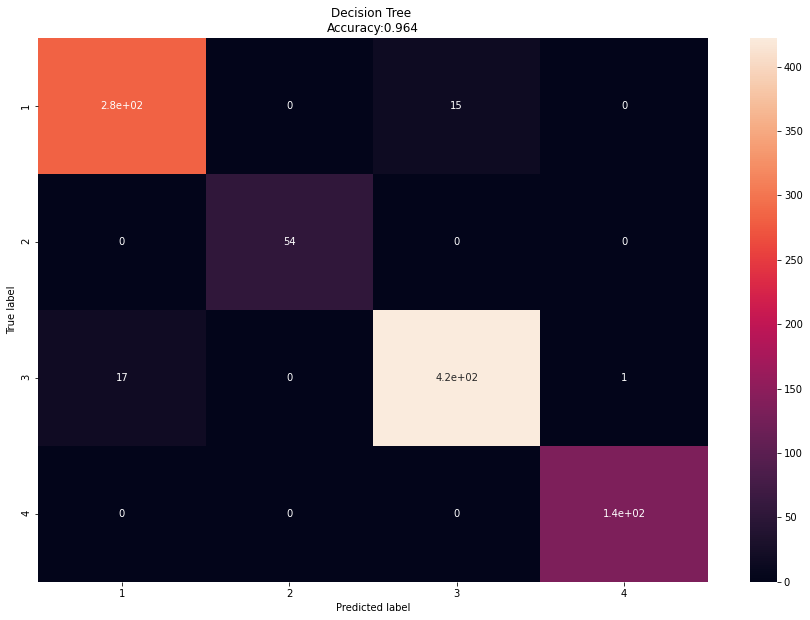

In [2377]:
# make color

import seaborn as sns
from matplotlib import cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# confusion matrices:
# predicted = clf1.predict(test_features)
# clf2 = DT
import pandas as pd

print('Hieu AI')
#cung co the dung pandas in ra bang ma tran nham lan
# y_actu = pd.Series(my_test_lable, name='Actual')
# y_pred = pd.Series(predicted, name='Predicted')
# pd.crosstab(y_actu, y_pred)


predicted = clf1.predict(test_features)

confusion_test = confusion_matrix(my_test_lable, predicted)

confusion_matrix(my_test_lable, predicted)

df_cm = pd.DataFrame(confusion_test,
                    index = [i for i in range(1, 5)], columns = [i for i in range(1, 5)])


plt.figure(figsize=(15,10))

sns.heatmap(df_cm, annot=True)

plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(my_test_lable, 
                                                                       predicted)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

print(classification_report(my_test_lable, predicted))
# Accuracy is calculated follow vertically
# for example:
# accuracy for the 3rd status: 58/(58+23)

#print('Feature importances: {}'.format(clf.feature_importances_))

4


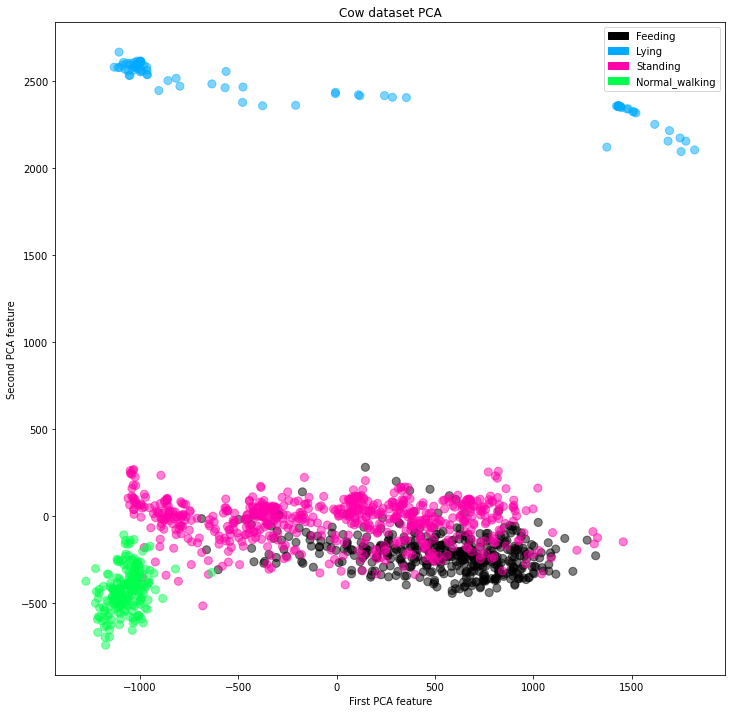

In [2378]:
# Visualisation: t-sne

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)
    print(num_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*'] #đánh dấu điểm
    #màu cho mảng các chấm
    color_array = ['#000000', '#00AAFF', '#FF00AA', '#00FF4C', '#ff0000', '#6e8216', '#ff6e00']
    #bản đồ màu
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels)
    #f = plt.figure(figsize=(10, 10))
    
    #vẽ biểu đồ mới kích thước 12 inch
    plt.figure(figsize=(12, 12))
#     plt.add_subplot(projection='3d')
    #matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None,
    #alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)[source]
    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.5, lw=1)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
#     plt.legend(handles=h)
    plt.legend(handles=h)
    
#     plt.set_xlabel('X Label')
#     plt.set_ylabel('Y Label')
#     plt.set_zlabel('Z Label')
    plt.xlabel('First PCA feature')
    plt.ylabel('Second PCA feature')
    plt.title('Cow dataset PCA');

    plt.show()


X_visual = train_features
y_visual = np.array(my_train_lable, dtype=np.uint8)

n_samples = 300
n_components = 2
perplexity = 30
RS = 1000

# from sklearn.manifold import PCA
from sklearn.decomposition import PCA

#TSNE
X_tsne = PCA(random_state=RS).fit_transform(X_visual)

plot_labelled_scatter(X_tsne, y_visual,['Feeding', 'Lying', 'Standing', 'Normal_walking'])


In [2379]:
# kiem tra 1 sample
i = 250
sample = [test_features[i]]
sample
res = clf1.predict(sample)
print('label kim tra: ', res)
print('label thuc te: ', my_test_lable[i])

[array([-891.72708333, -126.16805556,   38.15416667, -459.09930556,
         320.87916667, -747.58819444,  891.78925252,  133.99515452,
          52.37923986,  473.85164356,  339.70020663,  749.12266333,
          10.52994552,   45.12563786,   35.8865481 ,  117.31669846,
         111.50242502,   47.92344146, -903.2       , -224.66666667,
          -7.4       , -870.        ,  -80.9       ,  120.8       ,
        -672.1       ,   72.9       , -819.8       , -237.4       ,
         497.5       , -636.5       , -897.1       , -100.65555556,
          29.3       , -475.05      ,  316.42222222, -757.15      ])]

label kim tra:  [0]
label thuc te:  0


In [2380]:
# kiem tra  sample
dung = 0
tong = 1435
for i in range(tong):
    sample = list[test_features[i]] #them list mới bởi trinh minh hieu
    #sample
    #for sam in
    res = clf1.predict(sample)
    #print('label kim tra: ', res)
    #print('label thuc te: ', my_test_lable[i])
    if res == my_test_lable[i]:
        dung = dung + 1
        
print(dung)

TypeError: 'type' object is not subscriptable

In [ ]:
#hoc tap
import seaborn as sns
%matplotlib inline
tips = sns.load_dataset('tips')
tips.head()